In [1]:
!python -V

Python 3.9.13


In [2]:
import pandas as pd
import fastparquet
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [3]:
'''
# Read the Parquet file
df_train = pd.read_parquet('./data/green_tripdata_2021-01.parquet')
df_val = pd.read_parquet('./data/green_tripdata_2021-05.parquet')
df_test = pd.read_parquet('./data/green_tripdata_2021-07.parquet')
'''

"\n# Read the Parquet file\ndf_train = pd.read_parquet('./data/green_tripdata_2021-01.parquet')\ndf_val = pd.read_parquet('./data/green_tripdata_2021-05.parquet')\ndf_test = pd.read_parquet('./data/green_tripdata_2021-07.parquet')\n"

In [4]:
'''
# Save as CSV
df_train.to_csv('./data/green_tripdata_2021-01.csv', index=False)
df_val.to_csv('./data/green_tripdata_2021-02.csv', index=False)
df_test.to_csv('./data/green_tripdata_2021-07.csv', index=False)
'''

"\n# Save as CSV\ndf_train.to_csv('./data/green_tripdata_2021-01.csv', index=False)\ndf_val.to_csv('./data/green_tripdata_2021-02.csv', index=False)\ndf_test.to_csv('./data/green_tripdata_2021-07.csv', index=False)\n"

In [5]:
def read_dataframe(filename):
    df = pd.read_csv(filename)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime) 
    df.lpep_pickup_datetime  = pd.to_datetime(df.lpep_pickup_datetime)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 0) & (df.duration <= 60)] 

    categorical = ['PULocationID', 'DOLocationID']
    df.loc[:, categorical] = df[categorical].astype(str)
    
    return df

In [6]:
df_train = read_dataframe('./data/green_tripdata_2021-01.csv')
df_val = read_dataframe('./data/green_tripdata_2021-02.csv')
df_test = read_dataframe('./data/green_tripdata_2021-07.csv')

C:\Users\Sam Berchie\AppData\Local\Temp\ipykernel_20428\3219813684.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)
C:\Users\Sam Berchie\AppData\Local\Temp\ipykernel_20428\3219813684.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)
C:\Users\Sam Berchie\AppData\Local\Temp\ipykernel_20428\3219813684.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)


In [7]:
df_train.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,NaN,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,NaN,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,NaN,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,NaN,0.3,9.30,2.0,1.0,0.00,7.083333
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,...,-0.5,0.00,0.0,NaN,-0.3,-52.80,3.0,1.0,0.00,0.066667


In [8]:
df_val.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-05-01 00:49:47,2021-05-01 00:52:58,N,1.0,65,25,1.0,0.56,4.0,...,0.5,1.06,0.0,NaN,0.3,6.36,1.0,1.0,0.0,3.183333
1,2,2021-05-01 01:08:45,2021-05-01 01:25:36,N,1.0,25,223,1.0,9.37,27.5,...,0.5,7.20,0.0,NaN,0.3,36.00,1.0,1.0,0.0,16.850000
2,2,2021-05-01 00:12:39,2021-05-01 00:17:09,N,1.0,134,135,2.0,1.44,6.0,...,0.5,0.00,0.0,NaN,0.3,7.30,2.0,1.0,0.0,4.500000
3,2,2021-05-01 00:22:24,2021-05-01 00:33:03,N,1.0,82,226,1.0,1.78,9.0,...,0.5,3.80,0.0,NaN,0.3,14.10,1.0,1.0,0.0,10.650000
4,2,2021-05-01 00:53:41,2021-05-01 00:57:00,N,1.0,41,166,1.0,0.50,4.0,...,0.5,0.00,0.0,NaN,0.3,5.30,2.0,1.0,0.0,3.316667


In [9]:
df_test.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,1,2021-07-01 00:30:52,2021-07-01 00:35:36,N,1.0,74,168,1.0,1.20,6.0,...,0.5,0.00,0.0,NaN,0.3,7.30,2.0,1.0,0.0,4.733333
1,2,2021-07-01 00:25:36,2021-07-01 01:01:31,N,1.0,116,265,2.0,13.69,42.0,...,0.5,0.00,0.0,NaN,0.3,43.30,2.0,1.0,0.0,35.916667
2,2,2021-07-01 00:05:58,2021-07-01 00:12:00,N,1.0,97,33,1.0,0.95,6.5,...,0.5,2.34,0.0,NaN,0.3,10.14,1.0,1.0,0.0,6.033333
3,2,2021-07-01 00:41:40,2021-07-01 00:47:23,N,1.0,74,42,1.0,1.24,6.5,...,0.5,0.00,0.0,NaN,0.3,7.80,2.0,1.0,0.0,5.716667
4,2,2021-07-01 00:51:32,2021-07-01 00:58:46,N,1.0,42,244,1.0,1.10,7.0,...,0.5,0.00,0.0,NaN,0.3,8.30,2.0,1.0,0.0,7.233333


In [10]:
len(df_train), len(df_val), len(df_test)

(75356, 85107, 80772)

In [11]:
def add_combined_column(df, c1, c2, new_column_name):
    df[new_column_name] = df[c1].astype(str) + '_' + df[c2].astype(str)

In [12]:
add_combined_column(df_train, 'PULocationID', 'DOLocationID', 'PU_DO')
add_combined_column(df_val, 'PULocationID', 'DOLocationID', 'PU_DO')
add_combined_column(df_test, 'PULocationID', 'DOLocationID', 'PU_DO')

In [13]:
df_train

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,PU_DO
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.00,0.00,NaN,0.3,6.80,2.0,1.0,0.00,3.933333,43_151
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,2.81,0.00,NaN,0.3,16.86,1.0,1.0,2.75,8.750000,166_239
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,1.00,0.00,NaN,0.3,8.30,1.0,1.0,0.00,5.966667,41_42
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.00,0.00,NaN,0.3,9.30,2.0,1.0,0.00,7.083333,168_75
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,...,0.00,0.00,NaN,-0.3,-52.80,3.0,1.0,0.00,0.066667,265_265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,NaN,NaN,81,90,NaN,17.63,56.23,...,0.00,6.12,NaN,0.3,65.40,NaN,NaN,NaN,38.000000,81_90
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,NaN,NaN,35,213,NaN,18.36,46.66,...,12.20,6.12,NaN,0.3,65.28,NaN,NaN,NaN,38.000000,35_213
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,NaN,NaN,74,69,NaN,2.50,18.95,...,0.00,0.00,NaN,0.3,22.00,NaN,NaN,NaN,11.000000,74_69
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,NaN,NaN,168,215,NaN,14.48,48.87,...,0.00,6.12,NaN,0.3,58.04,NaN,NaN,NaN,27.000000,168_215


In [14]:
categorical =  ['PU_DO'] #['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

test_dicts = df_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(test_dicts)

In [15]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

In [20]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr =  lr.predict(X_val)

mse_lr = mean_squared_error(y_val, y_pred_lr, squared=False)
print(f'{mse_lr:.4f}')

8.1875


In [21]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)

y_pred_lasso =  lasso.predict(X_val)

mse_lasso = mean_squared_error(y_val, y_pred_lasso, squared=False)
print(f'{mse_lasso:.4f}')

9.7171


In [22]:
ridge = Ridge(alpha=0.001)
ridge.fit(X_train, y_train)

y_pred_ridge =  ridge.predict(X_val)

mse_ridge = mean_squared_error(y_val, y_pred_ridge, squared=False)
print(f'{mse_ridge:.4f}')

7.9611


In [23]:
y_pred_lr_test = lr.predict(X_test)
y_pred_lasso_test = lasso.predict(X_test)
y_pred_ridge_test = ridge.predict(X_test)

C:\Users\Sam Berchie\AppData\Local\Temp\ipykernel_20428\2463752397.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_lr_test, label='Linear Regression Test Prediction')
C:\Users\Sam Berchie\AppData\Local\Temp\ipykernel_20428\2463752397.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot

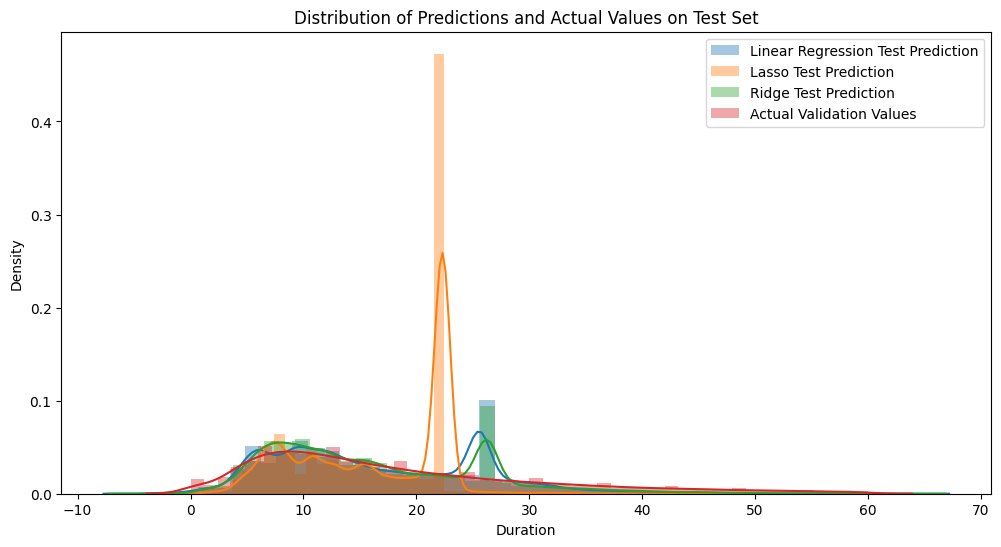

In [24]:
# Plotting the distribution
plt.figure(figsize=(12, 6))

# Plot predictions on the validation set
sns.distplot(y_pred_lr_test, label='Linear Regression Test Prediction')
sns.distplot(y_pred_lasso_test, label='Lasso Test Prediction')
sns.distplot(y_pred_ridge_test, label='Ridge Test Prediction')

# Plot actual values on the test set
sns.distplot(y_val, label='Actual Validation Values')

plt.legend()
plt.xlabel('Duration')
plt.title('Distribution of Predictions and Actual Values on Test Set')
plt.show()

In [26]:
best_model = None
best_model_name = None
if mse_lr <= mse_lasso and mse_lr <= mse_ridge:
    best_model = lr
    best_model_name = 'linear_regression'
elif mse_lasso <= mse_lr and mse_lasso <= mse_ridge:
    best_model = lasso
    best_model_name = 'lasso_regression'
else:
    best_model = ridge
    best_model_name = 'ridge_regression'

print(best_model_name)

ridge_regression


In [27]:
with open(f'models/{best_model_name}_model.bin', 'wb') as f_out:
    pickle.dump((dv, best_model), f_out)